In [1]:
# Data Science Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

# Model Specific Libraries
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import PolynomialFeatures

# Blocking Warning Boxes
import warnings
warnings.filterwarnings("ignore")

# Import group-made Zillow Funtions Module 
import wrangle


![Image of Zillow Logo](https://www.roundtablerealty.com/uploads/agent-1/699119.png)

<div align="center">
    

### By Joann Balraj & Jeanette Schulz 
### January 10, 2022

# Zillow: What is driving the errors in the Zestimates? 

</div align="center">
    

<hr style="border:2px solid blue"> </hr>

# Project Goal
For this project, we will look into finding drivers of error in the Zestimate. Using clustering methodologies, feature identification and comparison, visualizations, statistical testing, and regression models, we are to find drivers of error to predict log error. Zillows existing Zestimate model is pretty good but not perfect, which means modeling errors can be a very powerful way to find areas to improve that existing model. The goal of this project is to create a model to predict these Zestimate errors, and deliver our findings in a video presentation. 


<hr style="border:2px solid blue"> </hr>


# Executive Summary
The Linear Regression Model was our best model, which performed better than Baseline by having the lowest RMSE and a 𝑅2 of 0.000402. However, even though it performed better than the rest of the models, it still does not seem to be a significant predictor of error.


<hr style="border:2px solid blue"> </hr>

# Aquire

In [2]:
# Aquiring the data with function from wrangle.py
df = wrangle.get_zillow_data()
df = df.dropna()
df.head()

,bedrooms,bathrooms,squarefeet,year_built,regionidzip,fips,tax_value,logerror,transactiondate,longitude,latitude
0,4.0,3.5,3100.0,1998.0,96978.0,6059.0,1023282.0,0.025595,2017-01-01,-117869207.0,33634931.0
1,2.0,1.0,1465.0,1967.0,97099.0,6111.0,464000.0,0.055619,2017-01-01,-119281531.0,34449266.0
2,3.0,2.0,1243.0,1962.0,97078.0,6059.0,564778.0,0.005383,2017-01-01,-117823170.0,33886168.0
3,4.0,3.0,2376.0,1970.0,96330.0,6037.0,145143.0,-0.103410,2017-01-01,-118240722.0,34245180.0
4,4.0,3.0,2962.0,1950.0,96293.0,6037.0,773303.0,-0.001011,2017-01-01,-118179824.0,34145202.0


<hr style="border:2px solid blue"> </hr>

# Prepare
The data was prepared by functions created in the wrangle.py module that prepares the data by: Dropping all rows with NULL values, Dropping all rows that had any value as Zero, changing the datatypes of some columns, removing outliers, feature engineering, and seperating the data into train, test, validate for modeling and exploration of the data.



<hr style="border:2px solid blue"> </hr>


# Explore
The target variable will be logerror. Since we do not know the Zestimate of the home, nor the price it truely sold for, we only have the logerror as a reference for Zestimate error. So that is what we will explore.

In [3]:
# Define our alpha for 95% confidence!
alpha = 0.05

In [4]:
# Splitting our Data so we only explore on "train"
train, validate, test = wrangle.wrangle_zillow()

# Scaling data
train, validate, test = wrangle.Min_Max_Scaler(train, validate, test)

# Checking our dataframes
train.shape, validate.shape, test.shape

((25529, 12), (10942, 12), (9118, 12))


## Question 1: Does square footage affect Zestimate log error?

### Hypothesis :
$Ho$ : There is no correlation between square footage and log error

$Ha$ : Square footage and log error are correlated



In [5]:
train = train.dropna()
test = test.dropna()
validate = validate.dropna()

x = train.squarefeet
y = train.logerror

corr, p = stats.pearsonr(x, y)
corr, p

if p < alpha:
    print("We reject the null hypothesis")

else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


#### Null hypothesis is rejected.  Square footage and log error are correlated.


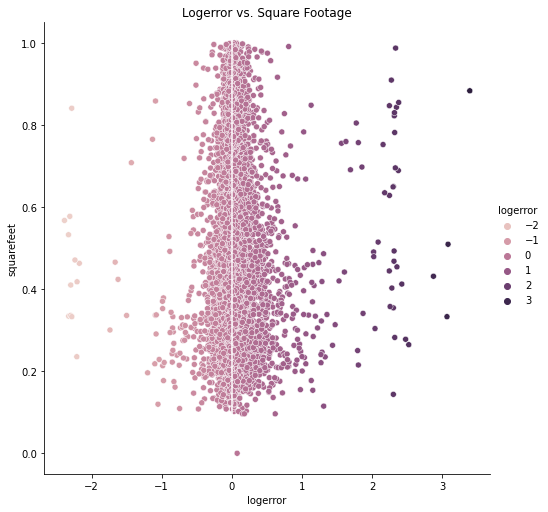

In [6]:
# Let's look at this visually 
sns.relplot(data=train, x="logerror", y="squarefeet", hue='logerror', height=7, aspect=1).set(title="Logerror vs. Square Footage");
plt.axvline(0, color='white');


## Question 2: If we control for month, does log error differ across county?


In [7]:
train['transactiondate'] = pd.to_datetime(train['transactiondate'])
train['month'] = pd.DatetimeIndex(train['transactiondate']).month

# binning transactiondate for comparison and visualization purposes
train['Months'] = pd.cut(train.month, [0,3,6,9])

train['county'] = train['fips'].apply(
        lambda x: 'Los Angeles' if x == 6037\
        else 'Orange' if x == 6059\
        else 'Ventura')

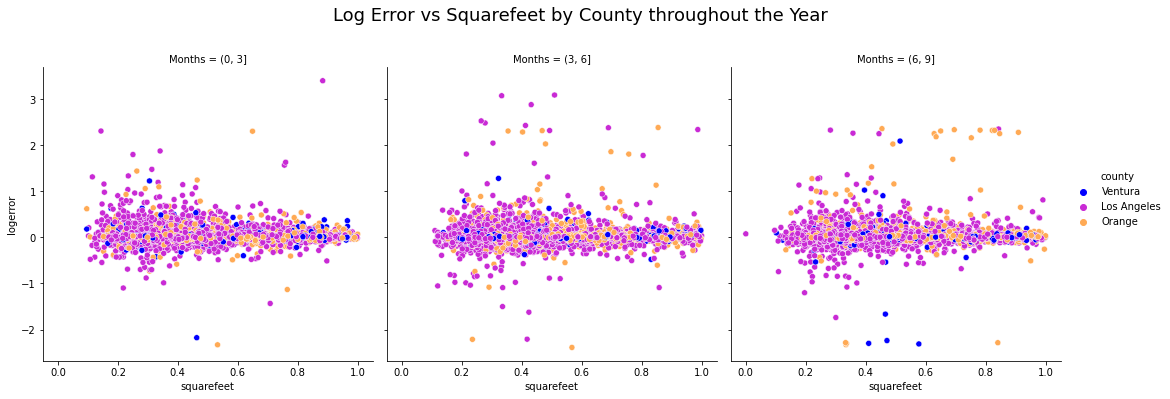

In [8]:
sns.relplot(x='squarefeet',y='logerror',data=train, hue='county',col='Months', height=5, palette='gnuplot2')
plt.suptitle("Log Error vs Squarefeet by County throughout the Year", y=1.1, size=18);

## Exploring with Clustering
#### Use Clustering to Identify Possible Features of Interest


### Clustering Model # 1:

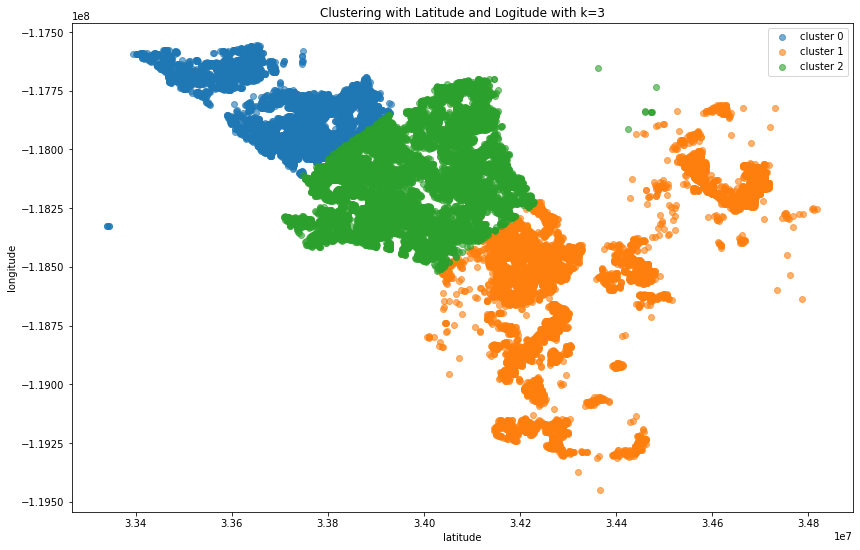

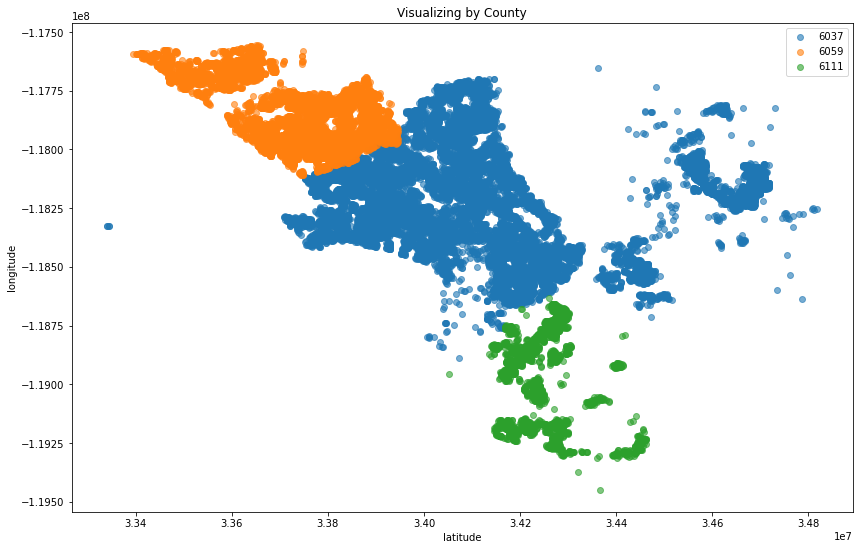

In [9]:
# Choose two features to create possible cluster
# Define independent variables for k-means
X = train[['latitude', 'longitude']]
scaler = MinMaxScaler().fit(X)
X_scaled_lat_long = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

# Define the thing and create 3 clusters
kmeans = KMeans(n_clusters=3, random_state=321)

# Fit the thing
kmeans.fit(X_scaled_lat_long )

# Use (predict using) the thing 
kmeans.predict(X_scaled_lat_long )
train['cluster'] = kmeans.predict(X_scaled_lat_long )

X_scaled_lat_long['cluster'] = kmeans.predict(X_scaled_lat_long )

# Saving this clustering for use in independence testing and possible modeling
train['cluster_lat_long'] = train['cluster']

# Visualizing the clusters by plotting them 
plt.figure(figsize=(14, 9))

for cluster, subset in train.groupby('cluster'):
    plt.scatter(subset.latitude, subset.longitude, label='cluster ' + str(cluster), alpha=.6, cmap='reds')
plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title("Clustering with Latitude and Logitude with k=3")
plt.show()

# compare against the actual data by county to compare how the clustering did
plt.figure(figsize=(14, 9))
for cluster, subset in train.groupby('fips'):
    plt.scatter(subset.latitude, subset.longitude, label=str(cluster), alpha=.6)

plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Visualizing by County')
plt.show();

______

### Clustering Model # 2:

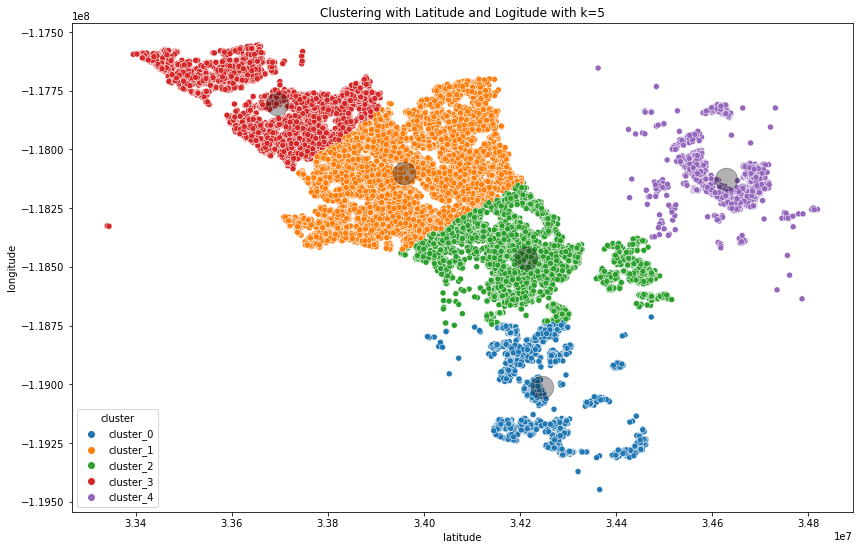

In [10]:
# We will create more clusters on the same features using a different k for grouping
X = train[['latitude', 'longitude']]

# use the create cluster function from wrangle.py with k value from inertia plot
train, X_scaled_lat_long_k5, scaler, kmeans, centroids = wrangle.create_cluster(train, X, 5)

# save this clustering for use in independence testing and possible modeling
train['cluster_lat_long_k5'] = [x.strip()[-1] for x in train['cluster']]
train['cluster_lat_long_k5'] = pd.to_numeric(train['cluster_lat_long_k5'],errors='coerce')

# use the create_scatter_plot function from wrangle.py to plot the data
wrangle.create_scatter_plot('latitude', 'longitude',train,kmeans, X_scaled_lat_long_k5, scaler)
plt.title("Clustering with Latitude and Logitude with k=5");

 Even though we only have 3 counties, the grouping by cluster looks good in this model and may be 
 helpful for predicting log error.

______

## Clustering Model # 3:
#### Repeat the clustering, this time with 3 different features.

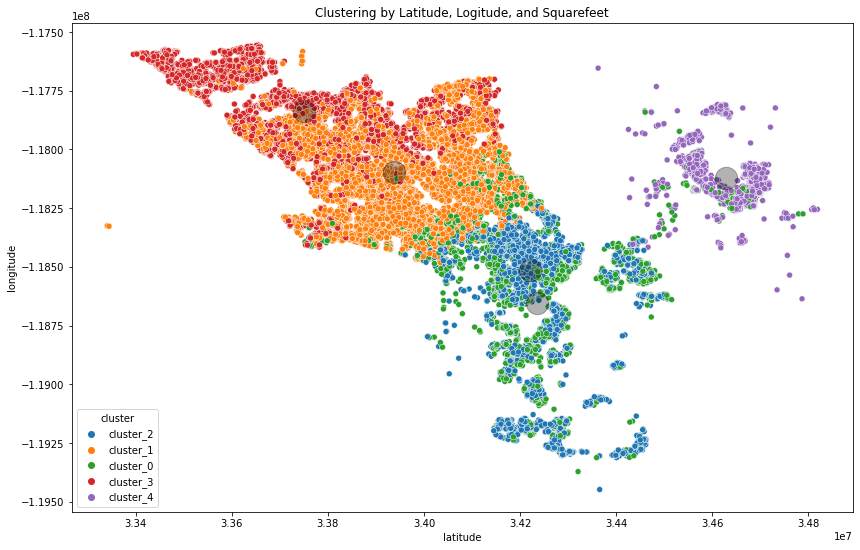

In [11]:
# we will create cluster on three features
X = train[['latitude','longitude','squarefeet']]

# use the create cluster function from wrangle.py with k value from inertia plot
train, X_scaled_lat_long_sqft, scaler, kmeans, centroids = wrangle.create_cluster(train, X, 5)

# save this clustering for use in independence testing and possible modeling
train['cluster_lat_long_sqft'] = [x.strip()[-1] for x in train['cluster']]
train['cluster_lat_long_sqft'] = pd.to_numeric(train['cluster_lat_long_sqft'],errors='coerce')

# use the create_scatter_plot function from wrangle.py to plot the cluster data
wrangle.create_scatter_plot('latitude', 'longitude', train, kmeans, X_scaled_lat_long_sqft, scaler)
plt.title("Clustering by Latitude, Logitude, and Squarefeet");

Since we're using 3 features for clustering, the clusters could be mapping to three dimensions and 
thus why some are overlapping throughout.


## Exploration Takeaways:
- Top features correlated to log error are
   - sq_footage
   - bedrooms
   - bathrooms
- We rejected the null hypothesis that the logerror is the same for all square footages. Log error depends on square footage.
- We rejected the null hypothesis that the logerror is the same for all counties. Log error depends on the county.
- Orange County has the largest log error, followed by Los Angeles County
- Log error varies by month and by county
- We rejected the null hypothesis that the log error is the same for properties with 4 bedrooms or less compared to those with more than 4 bedrooms. The log error is not the same for properties with 4 bedrooms or less compared to those with more than bedrooms.
- Clustering by latitude and longitude created clusters which mapped to the counties but looked to create an additional cluster which fit the map well.
- Latitude and longitude independent tests comparing log errors rejected the null hypothesis meaning they are correlated to log error.
- Log error is dependent on square footage and number of bedrooms.
- Cluster # 1 (Latitude/Longitude), # 3 (Lat/Long/Square Feet), # 4 (Latitude/Square Feet), # 5 (Longitude/Square Feet) rejected the null hypothesis that there was no relationship between log error so they can be used in modeling.





<hr style="border:2px solid blue"> </hr>




# Modeling

To keep this report short and simple, all modeling code can be found in `jos-zillow-workbook.ipynb` or our `wrangle.py`.

In [12]:
wrangle.return_model_results(train,validate,test)

RMSE using Mean
Train/In-Sample:  0.16 
Validate/Out-of-Sample:  0.13
RMSE using Median
Train/In-Sample:  0.16 
Validate/Out-of-Sample:  0.13
RMSE for OLS using LinearRegression
Training/In-Sample:  0.16298186939436773 
Validation/Out-of-Sample:  0.14229426250640562
RMSE for Lasso + Lars
Training/In-Sample:  0.16313126773021655 
Validation/Out-of-Sample:  0.12846401072925018
RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.16291450726809809 
Validation/Out-of-Sample:  0.12834677112228457
RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.16274309710145968 
Validation/Out-of-Sample:  0.12829770411613117
RMSE for OLS using Linear Regression Model
Training/In-Sample:  0.16298186939436773 
Validation/Out-of-Sample:  0.1284157534755211 
Test/Out-of-Sample:  0.15465684546353797


,model,RMSE_validate,r^2_validate
0,median_baseline,0.163478,0.000000
1,OLS Regressor,0.142294,0.000625
2,lasso_alpha_4,0.180850,0.000000
3,quadratic,0.180712,0.001519
4,3degree_quadratic,0.180655,0.002158
5,TEST_OLS,0.154657,-0.000242


### Modeling Takeaways:
Linear Regression Model performed better than the baseline by having the lowest RMSE and a $R^2$ of 0.000402. Although it performed better than the rest of the models, it does not look to be a significant predictor of error, just barely beating the baseline.


<hr style="border:2px solid blue"> </hr>

# Final Takeaways:
 
____ 

### What Does This Mean for our Zestimate?
 - Features chosen for the model that may be drivers of error include bedrooms, bathrooms, square footage, latitude and longitude
 - Even though the model performed slightly better than the baseline, all models seem to indicate that there may not be many significant drivers of log error from our current findings.
 
### Next Steps:
 - With more time, we would like to try running models on the clusters since they showed dependency on log error
 - We would also like to keep exploring other features and clusters in the models